# Computer Vision Project

In [1]:
import pandas as pd
import numpy as np
import cv2

import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model


import random
from tensorflow.keras import backend

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from skimage.transform import resize
import seaborn as sns

import h5py

from google.colab import drive
drive.mount('/content/drive')

import warnings
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

Mounted at /content/drive


**PART - A**

## Domain Entertainment
CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.

**PROJECT OBJECTIVE**: To build a face detection system..


In [ ]:
data = np.load('/content/drive/My Drive/AIML/Computer Vision/project/images.npy', allow_pickle=True)
print("df shape =", data.shape)

df shape = (409, 2)


In [ ]:
images = data[:, 0]
labels = data[:, 1]

In [ ]:
import numpy as np

def convert_to_three_channels(image):
    if len(image.shape) == 2:
        # Grayscale image with 2 channels - duplicate the channel to create 3 channels
        return np.stack((image, image, image), axis=2)
    elif image.shape[2] == 3:
        return image  # Already 3 channels, no conversion needed
    elif image.shape[2] == 4:
        # Remove the alpha channel (last channel) to convert to 3 channels
        return image[:, :, :3]
    else:
        print("else ")
        return None  # Invalid number of channels


In [ ]:
three_channel_images = []
three_channel_labels = []
gray_count = 0
alpha_count = 0

for idx, i in enumerate(images):
    converted_image = convert_to_three_channels(i)
    if converted_image is not None:
        three_channel_images.append(converted_image)
        three_channel_labels.append(labels[idx])
    elif len(i.shape) == 2:
        gray_count += 1
    elif i.shape[2] == 4:
        alpha_count += 1

gray_count, alpha_count, len(images)


(0, 0, 409)

In [ ]:
# Unify the shape of all images (resize to a common shape)
common_image_shape = (128, 128,3)

unified_images = []
masks = []
original_images = []

for img, label in zip(three_channel_images, three_channel_labels):
    resized_img = cv2.resize(img, (common_image_shape[1], common_image_shape[0]))
    mask = np.zeros((common_image_shape[0], common_image_shape[1]), dtype=np.uint8)
    for face in label:
        points = face['points']
        x_values = [p['x'] for p in points]
        y_values = [p['y'] for p in points]
        x_min, x_max = min(x_values), max(x_values)
        y_min, y_max = min(y_values), max(y_values)

        mask[int(y_min*common_image_shape[0]):int(y_max*common_image_shape[0]),
             int(x_min*common_image_shape[1]):int(x_max*common_image_shape[1])] = 1

    masked_img = np.where(mask[:, :, np.newaxis] > 0, 1, resized_img)

    flattened_img = masked_img / 255.0
    unified_images.append((flattened_img))
    masks.append(mask)

    original_images.append(img)

unified_images = np.array(unified_images)
Y = np.array(masks)


In [ ]:
X_train = unified_images[:400]
Y_train = Y[:400]

X_test = unified_images[400:]
Y_test = Y[400:]

print("Shape of X_train (training features):", X_train.shape)
print("Shape of Y_train (training labels):", Y_train.shape)
print("Shape of X_test (testing features):", X_test.shape)
print("Shape of Y_test (testing labels):", Y_test.shape)

Shape of X_train (training features): (400, 128, 128, 3)
Shape of Y_train (training labels): (400, 128, 128)
Shape of X_test (testing features): (9, 128, 128, 3)
Shape of Y_test (testing labels): (9, 128, 128)


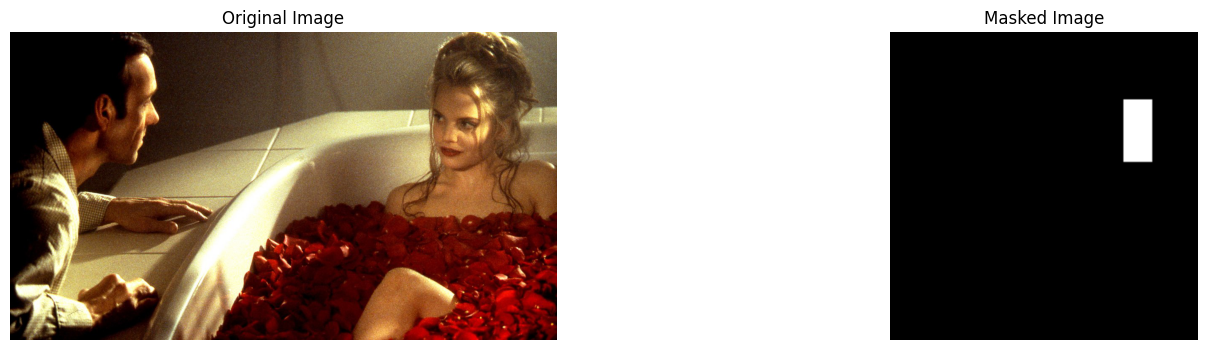

In [ ]:
random_index = np.random.randint(0, len(X_train))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_images[random_index], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
#plt.imshow(X_train[random_index][1], cmap='gray')
plt.imshow(Y_train[random_index], cmap='gray')
plt.title('Masked Image')
plt.axis('off')

plt.show()

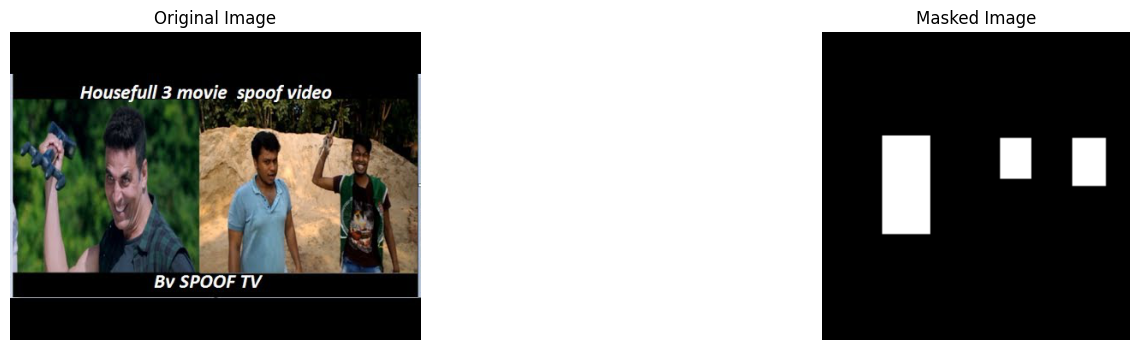

In [ ]:
random_index = np.random.randint(0, len(X_train))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_images[random_index], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Y_train[random_index], cmap='gray')
plt.title('Masked Image')
plt.axis('off')

plt.show()

In [ ]:
def build_model():
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

model = build_model()
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])


In [ ]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_tensor = tf.convert_to_tensor(Y_test, dtype=tf.float32)

history = model.fit(X_train_tensor, Y_train_tensor, validation_data=(X_test_tensor, Y_test_tensor), epochs=10, batch_size=16)

Epoch 1/10
25/25 [==============================] - 19s 117ms/step - loss: 1.2718 - dice_coefficient: 0.2717 - val_loss: 0.8205 - val_dice_coefficient: 0.4600
Epoch 2/10
25/25 [==============================] - 1s 25ms/step - loss: 0.9018 - dice_coefficient: 0.4244 - val_loss: 0.7765 - val_dice_coefficient: 0.4682
Epoch 3/10
25/25 [==============================] - 1s 25ms/step - loss: 0.7820 - dice_coefficient: 0.4919 - val_loss: 0.6738 - val_dice_coefficient: 0.5439
Epoch 4/10
25/25 [==============================] - 1s 27ms/step - loss: 0.7118 - dice_coefficient: 0.5369 - val_loss: 0.6890 - val_dice_coefficient: 0.5471
Epoch 5/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6498 - dice_coefficient: 0.5760 - val_loss: 0.6670 - val_dice_coefficient: 0.5710
Epoch 6/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6475 - dice_coefficient: 0.5768 - val_loss: 0.7177 - val_dice_coefficient: 0.5506
Epoch 7/10
25/25 [==============================] - 1s 2

In [ ]:
history = model.fit(X_train_tensor, Y_train_tensor, validation_data=(X_test_tensor, Y_test_tensor), epochs=10, batch_size=32)

Epoch 1/10
13/13 [==============================] - 5s 45ms/step - loss: 0.4994 - dice_coefficient: 0.6735 - val_loss: 0.8057 - val_dice_coefficient: 0.5823
Epoch 2/10
13/13 [==============================] - 1s 41ms/step - loss: 0.4536 - dice_coefficient: 0.7085 - val_loss: 0.7339 - val_dice_coefficient: 0.5963
Epoch 3/10
13/13 [==============================] - 1s 41ms/step - loss: 0.3988 - dice_coefficient: 0.7385 - val_loss: 0.7901 - val_dice_coefficient: 0.5989
Epoch 4/10
13/13 [==============================] - 1s 41ms/step - loss: 0.3624 - dice_coefficient: 0.7675 - val_loss: 0.7614 - val_dice_coefficient: 0.6147
Epoch 5/10
13/13 [==============================] - 1s 41ms/step - loss: 0.3332 - dice_coefficient: 0.7820 - val_loss: 0.7959 - val_dice_coefficient: 0.6142
Epoch 6/10
13/13 [==============================] - 1s 43ms/step - loss: 0.3154 - dice_coefficient: 0.7978 - val_loss: 0.8364 - val_dice_coefficient: 0.6070
Epoch 7/10
13/13 [==============================] - 1s 42m

In [ ]:
history = model.fit(X_train_tensor, Y_train_tensor, validation_data=(X_test_tensor, Y_test_tensor), epochs=25, batch_size=32)

Epoch 1/25
13/13 [==============================] - 1s 50ms/step - loss: 0.2593 - dice_coefficient: 0.8349 - val_loss: 0.7847 - val_dice_coefficient: 0.6347
Epoch 2/25
13/13 [==============================] - 1s 42ms/step - loss: 0.2531 - dice_coefficient: 0.8380 - val_loss: 0.8404 - val_dice_coefficient: 0.6173
Epoch 3/25
13/13 [==============================] - 1s 42ms/step - loss: 0.2452 - dice_coefficient: 0.8411 - val_loss: 0.8769 - val_dice_coefficient: 0.6093
Epoch 4/25
13/13 [==============================] - 1s 42ms/step - loss: 0.2233 - dice_coefficient: 0.8588 - val_loss: 0.8597 - val_dice_coefficient: 0.6237
Epoch 5/25
13/13 [==============================] - 1s 42ms/step - loss: 0.2011 - dice_coefficient: 0.8693 - val_loss: 0.8466 - val_dice_coefficient: 0.6245
Epoch 6/25
13/13 [==============================] - 1s 42ms/step - loss: 0.1884 - dice_coefficient: 0.8792 - val_loss: 0.8698 - val_dice_coefficient: 0.6251
Epoch 7/25
13/13 [==============================] - 1s 41m

In [ ]:
history = model.fit(X_train_tensor, Y_train_tensor, validation_data=(X_test_tensor, Y_test_tensor), epochs=50, batch_size=32)

Epoch 1/50
13/13 [==============================] - 1s 55ms/step - loss: 0.1144 - dice_coefficient: 0.9278 - val_loss: 0.9760 - val_dice_coefficient: 0.6236
Epoch 2/50
13/13 [==============================] - 1s 46ms/step - loss: 0.1102 - dice_coefficient: 0.9296 - val_loss: 0.9946 - val_dice_coefficient: 0.6348
Epoch 3/50
13/13 [==============================] - 1s 42ms/step - loss: 0.1099 - dice_coefficient: 0.9294 - val_loss: 0.9894 - val_dice_coefficient: 0.6288
Epoch 4/50
13/13 [==============================] - 1s 42ms/step - loss: 0.1012 - dice_coefficient: 0.9349 - val_loss: 0.9404 - val_dice_coefficient: 0.6403
Epoch 5/50
13/13 [==============================] - 1s 42ms/step - loss: 0.0909 - dice_coefficient: 0.9409 - val_loss: 1.0035 - val_dice_coefficient: 0.6268
Epoch 6/50
13/13 [==============================] - 1s 44ms/step - loss: 0.0811 - dice_coefficient: 0.9473 - val_loss: 1.0175 - val_dice_coefficient: 0.6336
Epoch 7/50
13/13 [==============================] - 1s 41m

In [ ]:
# Evaluate the model
evaluation = model.evaluate(X_test_tensor, Y_test_tensor, verbose=1)
print("Dice Coefficient:", evaluation[1])
print("Dice Loss:", evaluation[0])

1/1 [==============================] - 0s 112ms/step - loss: 1.1868 - dice_coefficient: 0.6289
Dice Coefficient: 0.6289082169532776
Dice Loss: 1.1868425607681274


1/1 [==============================] - 2s 2s/step


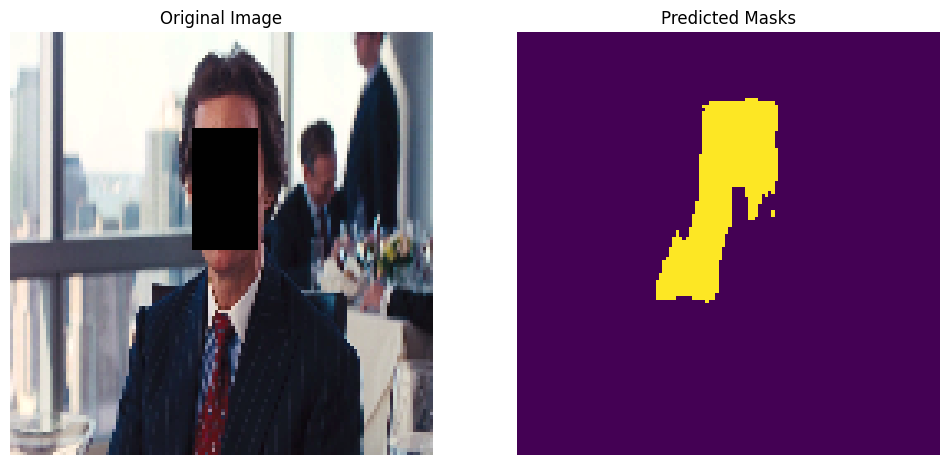

In [ ]:
test_image_index = 3
test_image = X_test_tensor[test_image_index]
test_image = np.squeeze(test_image)

predicted_masks = model.predict(np.expand_dims(test_image, axis=0))

threshold = 0.5
predicted_masks_binary = (predicted_masks > threshold).astype(np.uint8)


resized_masks = []
for mask in predicted_masks_binary:
    resized_mask = cv2.resize(mask.squeeze(), (test_image.shape[1], test_image.shape[0]))
    resized_masks.append(resized_mask)

stacked_masks = np.stack(resized_masks, axis=-1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stacked_masks)
plt.title('Predicted Masks')
plt.axis('off')

plt.show()


**PART B**

## Domain : Entertainment
**CONTEXT**: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

**PROJECT OBJECTIVE:** To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

In [ ]:
import os
import cv2
import zipfile

project_path = '/content/drive/My Drive/AIML/Computer Vision/project/'
images_zip_path = project_path + "training_images.zip"

extracted_folder_path = project_path + 'training_images'

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip(images_zip_path, project_path)

In [ ]:
def read_images(folder_path):
    images = []
    print(folder_path)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append((filename, img))
    return images

images = read_images(extracted_folder_path)

/content/drive/My Drive/AIML/Computer Vision/project/training_images


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

faces_data = []

for img_name, img in images:
    faces = detect_faces(img)
    for (x, y, w, h) in faces:
        faces_data.append({
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'Total_Faces': len(faces),
            'Image_name': img_name
        })


In [ ]:
faces_df = pd.DataFrame(faces_data)
print(faces_df)

       x    y    w    h  Total_Faces      Image_name
0    138  166  373  373            1  real_01031.jpg
1    117  179  368  368            1  real_01008.jpg
2     83  150  408  408            1  real_01073.jpg
3     40   71  483  483            1  real_00978.jpg
4     93  167  402  402            1  real_01077.jpg
..   ...  ...  ...  ...          ...             ...
944   15   71  455  455            1  real_00995.jpg
945  118  150  375  375            1  real_01056.jpg
946   88   52  432  432            2  real_00977.jpg
947  428  484  110  110            2  real_00977.jpg
948   79  114  442  442            1  real_00985.jpg

[949 rows x 6 columns]


In [ ]:
output_csv_path = project_path + 'faces_metadata.csv'
faces_df.to_csv(output_csv_path, index=False)
print('Faces metadata saved to:', output_csv_path)


Faces metadata saved to: /content/drive/My Drive/AIML/Computer Vision/project/faces_metadata.csv


**PART C**

#DOMAIN: Face Recognition
CONTEXT: Company X intends to build a face identification model to recognise human faces.

**PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

In [2]:
# Q1
import zipfile
import os
project_path = '/content/drive/My Drive/AIML/Computer Vision/project/'
images_zip_path_PINS = project_path + "PINS.zip"
extracted_folder_path_PINS = project_path + 'PINS'


In [3]:
# Unzip the dataset
with zipfile.ZipFile(images_zip_path_PINS, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path_PINS)


In [4]:
# Q2
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file)

In [5]:
# Q3

def load_metadata(path):
    metadata = []
    for root, dirs, files in os.walk(path):
      # Exclude '__MACOSX' from directories to iterate
      if '__MACOSX' in dirs:
            dirs.remove('__MACOSX')
      for file in files:
        # Check file extension. Allow only jpg/jpeg' files.
        ext = os.path.splitext(file)[1]
        name = os.path.splitext(file)[0]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(IdentityMetadata(root, name, file))
    return np.array(metadata)


In [6]:
# Write a function to read image using opencv and convert it from BGR to RGB

import cv2
import os
from google.colab.patches import cv2_imshow

def load_image(image_path):
    # Read the image in BGR format
    print(image_path)
    image_bgr = cv2.imread(image_path)

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Display the image using cv2_imshow
    # cv2_imshow(image_rgb)

    return image_rgb

In [7]:
metadata = load_metadata(extracted_folder_path_PINS)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [9]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

# Load the VGG Face model
model=vgg_face()
model.load_weights(project_path + "vgg_face_weights.h5")

In [10]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [12]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg1.jpg
(224, 224, 3)
1/1 [==============================] - 1s 683ms/step
(2622,)


In [13]:
embeddings = np.zeros((metadata.shape[0], 2622))
embeddings = []

for i, m in enumerate(metadata):
  img_path = metadata[i].image_path()
  img = load_image(img_path)

  if image is not None:
    img = (img / 255.).astype(np.float32)

    img = cv2.resize(img, dsize = (224,224))
    print(img.shape)
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  else:
    embedding = np.zeros(2622)

  embeddings.append(embedding_vector)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 639ms/step
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson92.jpg
(224, 224, 3)
1/1 [==============================] - 1s 627ms/step
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson36.jpg
(224, 224, 3)
1/1 [==============================] - 1s 630ms/step
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson22.jpg
(224, 224, 3)
1/1 [==============================] - 1s 632ms/step
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson23.jpg
(224, 224, 3)
1/1 [==============================] - 1s 630ms/step
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson37.jpg
(224, 224, 3)
1/1 [==============================] - 1s 785ms/step
/content/drive/My Drive/AIML/Computer Vis

In [14]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg44.jpg
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg45.jpg
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_mark zuckerberg/mark zuckerberg44.jpg
/content/drive/My Drive/AIML/Computer Vision/project/PINS/PINS/pins_amber heard face/amber heard face147.jpg


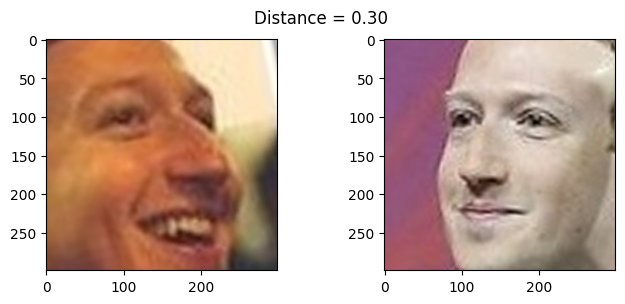

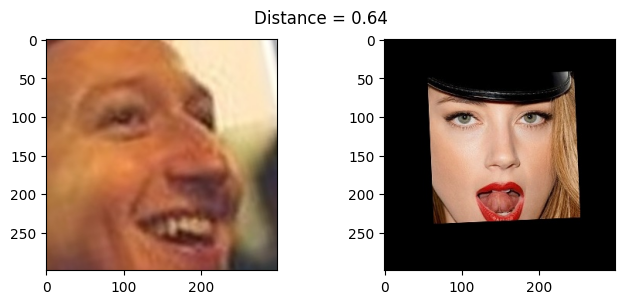

In [15]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

In [16]:
embeddings_arr = np.array(embeddings)

In [17]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

X_train = embeddings_arr[train_idx]
X_test = embeddings_arr[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [18]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(9573, 2622) (1197, 2622)
(9573,) (1197,)


In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
all_labels = np.concatenate((y_train, y_test))
label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)

In [22]:
from sklearn.svm import SVC

svm_classifier = SVC()
svm_classifier.fit(X_train_pca, y_train_encoded)

SVC()

In [46]:
import pickle
model_file_path = '/content/drive/My Drive/AIML/Computer Vision/project/svm_model.pkl'

def save_model(model, model_file_path):
    with open(model_file_path, 'wb') as f:
        pickle.dump(model, f)

    print("Model saved to", model_file_path)


save_model(svm_classifier, model_file_path)

Model saved to /content/drive/My Drive/AIML/Computer Vision/project/svm_model.pkl


In [23]:
from sklearn.metrics import accuracy_score

y_pred = svm_classifier.predict(X_test_pca)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", accuracy)

Accuracy: 0.0


In [24]:
# Test image paths
test_image_paths = ['/content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Benedict Cumberbatch/Benedict Cumberbatch9.jpg', '/content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson4.jpg']


Test Image: /content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Benedict Cumberbatch/Benedict Cumberbatch9.jpg


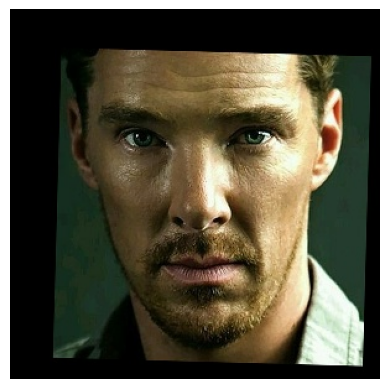

Test Image: /content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson4.jpg


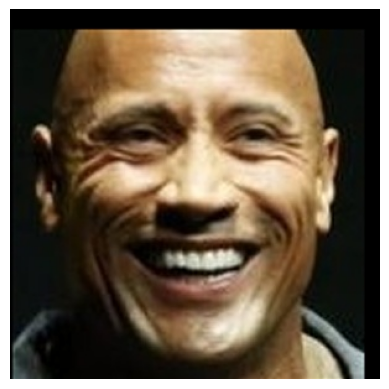

In [25]:
# Display test images
for test_image_path in test_image_paths:
    print('Test Image:', test_image_path)

    # Load the image
    img = cv2.imread(test_image_path)

    # Check if the image was loaded successfully
    if img is None:
        print('Error: Unable to load image', test_image_path)
        continue

    # Convert BGR to RGB (OpenCV loads images in BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


In [49]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image

def generate_embedding1(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embeddings = model.predict(x)
    return embeddings.flatten()

In [50]:
# Function to predict the person using the SVM model
def predict_person1(image_path, pca_model, svm_model, label_encoder):
    embedding = generate_embedding1(image_path)
    embedding = np.reshape(embedding, (1, -1))
    pca_result = pca_model.transform(embedding)
    predicted_label = svm_model.predict(pca_result)
    predicted_person = label_encoder.inverse_transform(predicted_label)[0]
    return predicted_person


Test Image: /content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Benedict Cumberbatch/Benedict Cumberbatch9.jpg


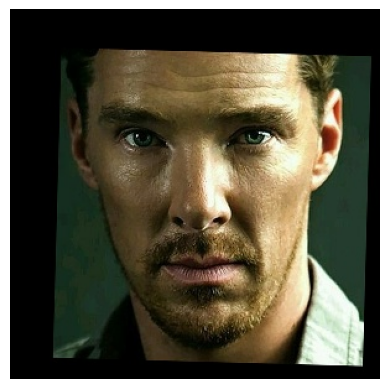

1/1 [==============================] - 1s 644ms/step
Predicted Person for /content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Benedict Cumberbatch/Benedict Cumberbatch9.jpg : david mazouz6
Test Image: /content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson4.jpg


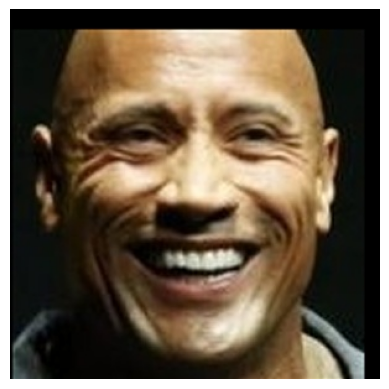

1/1 [==============================] - 1s 623ms/step
Predicted Person for /content/drive/MyDrive/AIML/Computer Vision/project/PINS/PINS/pins_Dwayne Johnson/Dwayne Johnson4.jpg : david mazouz6


In [51]:
# Display test images and predict using SVM model
for test_image_path in test_image_paths:
    print('Test Image:', test_image_path)

    img = cv2.imread(test_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    predicted_person = predict_person1(test_image_path, pca, svm_classifier, label_encoder)
    print('Predicted Person for', test_image_path, ':', predicted_person)
